In [1]:
%load_ext autoreload
%autoreload 2

In [289]:
import saopaulo
import models
import mscthesis
import pandas as pd
import geopandas as gpd
import validation
import numpy as np
import datetime
import genericvalidation

In [5]:
sampler = models.Sampler(
    model=models.PreferentialReturn(
        p=0.2,
        gamma=0.8,
        region_sampling=models.RegionTransitionZipf(
            beta=0.05,
        ),
        jump_size_sampling=models.JumpSizeTrueProb(),
    ),
    daily_trips_sampling=models.NormalDistribution(3.14, 1.8),
    n_days=7*20,
    geotweets_path="",
)

In [10]:
geotweets = mscthesis.read_geotweets_raw("../../dbs/saopaulo/geotweets.csv").set_index('userid')

# Only look at weekday trips
#geotweets = geotweets[(geotweets['weekday'] < 6) & (0 < geotweets['weekday'])]

# Remove users who don't have home visit in geotweets
home_visits = geotweets.query("label == 'home'").groupby('userid').size()
geotweets = geotweets.loc[home_visits.index]

# Remove users with less than 20 tweets
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 20].index)

# Remove users with only one region
regioncount = geotweets.groupby(['userid', 'region']).size().groupby('userid').size()
geotweets = geotweets.drop(labels=regioncount[regioncount < 2].index)

# Ensure the tweets are sorted chronologically
geotweets = geotweets.sort_values(by=['userid', 'createdat'])

In [12]:
geotweets.shape

(3999440, 12)

In [145]:
baseline = models.geotweets_to_visits(geotweets)

In [127]:
geotweetsx = geotweets.loc[geotweets.groupby('userid').size()[:1000].index]

In [ ]:
print(datetime.datetime.now())
visits = sampler.sample(geotweets)
print(datetime.datetime.now())

In [209]:
visits

,day,timeslot,kind,latitude,longitude,region
userid,,,,,,
2542,0,0,region,-23.562703,-46.697775,235
2542,0,1,region,-23.571774,-46.708113,171
2542,0,2,region,-23.503767,-46.844465,266
2542,1,0,region,-23.562703,-46.697775,235
2542,1,1,region,-23.562703,-46.697775,235
...,...,...,...,...,...,...
803997550726549504,138,5,region,-23.571815,-46.708524,6
803997550726549504,139,0,region,-23.571815,-46.708524,6
803997550726549504,139,1,region,-23.571815,-46.708524,6


In [210]:
visits.to_csv('./../../dbs/saopaulo/visits.csv')

In [130]:
zones = saopaulo.zones()

In [131]:
odm = saopaulo.odm()

In [133]:
distance = genericvalidation.zone_distances(zones)
qgrps = genericvalidation.distance_quantiles(distance)

Calculating distances between zones...


In [167]:
baseline_odm = genericvalidation.visits_to_odm(baseline, zones)

Aligning region-visits to Sampers zones...
removed 692022 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
3307418 visits left after alignment


In [211]:
model_odm = genericvalidation.visits_to_odm(visits, zones)

Aligning region-visits to Sampers zones...
removed 79684 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 10298 point-visits due to missing zone geom
6542365 visits left after alignment


In [174]:
baseline_odm

1    1      5.078977e-02
     2      2.542416e-04
     3      2.691078e-04
     4      5.279003e-04
     5      9.623562e-04
                ...     
517  513    0.000000e+00
     514    6.067819e-07
     515    2.123737e-06
     516    5.764428e-06
     517    4.550865e-05
Length: 267289, dtype: float64

In [212]:
dms = validation.DistanceMetrics().compute(qgrps, [odm, baseline_odm, model_odm], ['groundtruth', 'baseline', 'model'])

In [223]:
import plots
import matplotlib.pyplot as plt

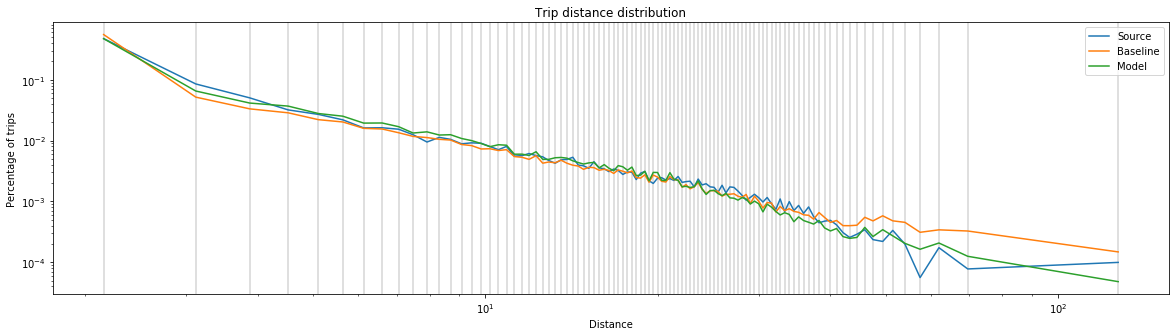

In [280]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
plots.generic_plot_dist_distribution(
    ax, 
    [
        dms['groundtruth_sum'],
        dms['baseline_sum'],
        dms['model_sum'],
    ], ["Source", "Baseline", "Model"])

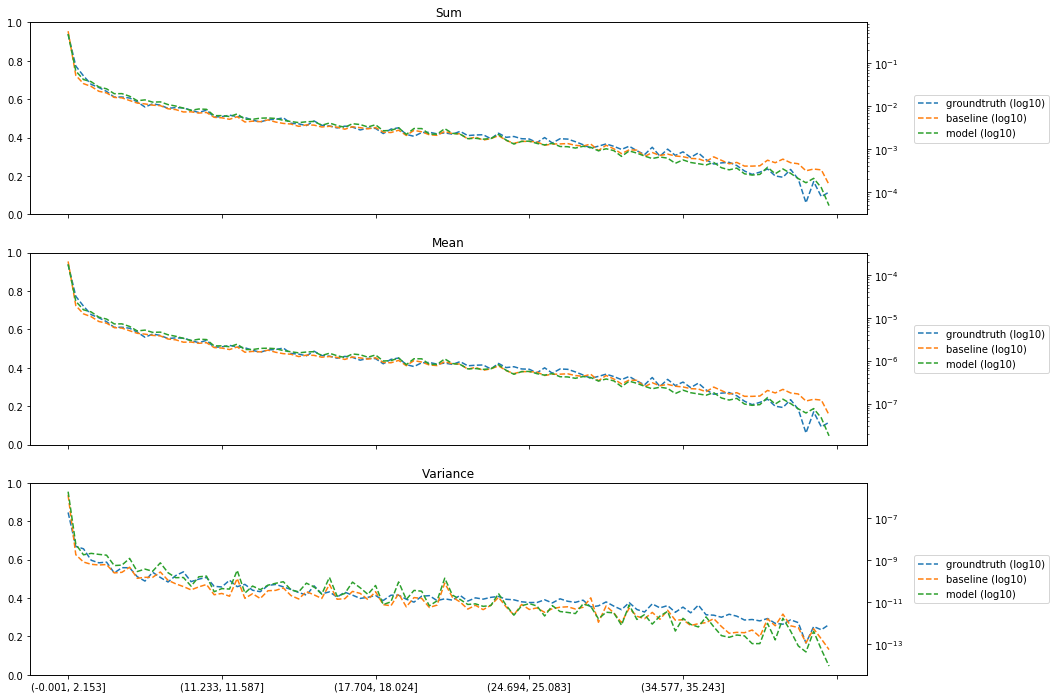

In [232]:
_ = plots.plot_distance_metrics(dms, ['groundtruth', 'baseline', 'model'], show_norm=False)

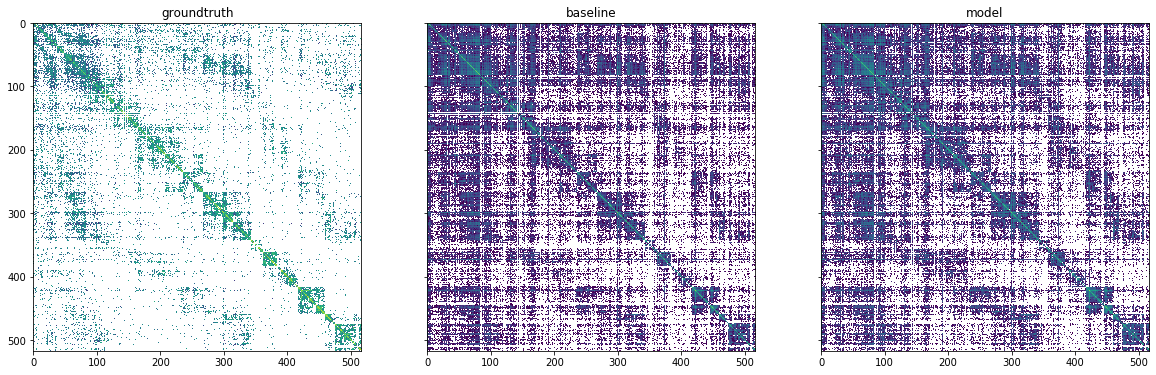

In [215]:
_ = plots.plot_odms([odm, baseline_odm, model_odm], ['groundtruth', 'baseline', 'model'])

In [216]:
model_se = np.square(np.subtract(dms['groundtruth_sum'], dms['model_sum']))
baseline_se = np.square(np.subtract(dms['groundtruth_sum'], dms['baseline_sum']))
print("Model MSE: {:.5e}".format(model_se.mean()))
print("Baseline MSE: {:.5e}".format(baseline_se.mean()))

Model MSE: 5.85882e-06
Baseline MSE: 7.73749e-05


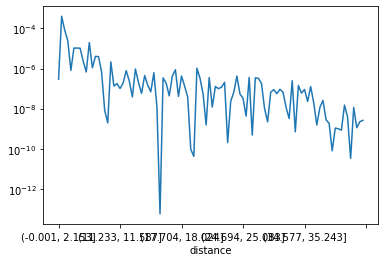

In [217]:
model_se.plot(logy=True)

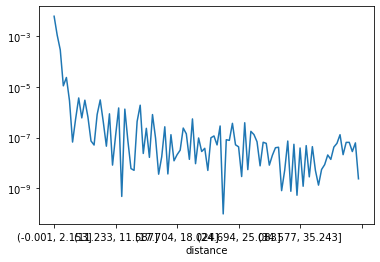

In [218]:
baseline_se.plot(logy=True)